In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchinfo import summary
from torchvision import datasets
from torchvision import models

torch.set_default_device('cuda')

c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("corn-maize-disease")

<Experiment: artifact_location='mlflow-artifacts:/226135086555734073', creation_time=1710461188239, experiment_id='226135086555734073', last_update_time=1710468048012, lifecycle_stage='active', name='corn-maize-disease', tags={}>

In [27]:
import gc

gc.collect()

21856

In [3]:
def tv_split(dataset, split_size=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=split_size)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['validation'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

In [4]:
transform = transforms.Compose(
    [transforms.Resize((300, 300)), transforms.ToTensor(), transforms.RandomHorizontalFlip(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
traindata = datasets.ImageFolder(".\\dataset\\data", transform=transform)
validdata = datasets.ImageFolder(".\\dataset\\data", transform=transform)

dataset = tv_split(traindata)
trainloader = torch.utils.data.DataLoader(dataset['train'], batch_size=60, shuffle=True, )
test_data = tv_split(dataset['validation'], 0.50)
validationloader = torch.utils.data.DataLoader(test_data['train'], batch_size=60, shuffle=False,
                                               generator=torch.Generator(device='cuda'))
testloader = torch.utils.data.DataLoader(test_data['validation'], batch_size=15, shuffle=False,
                                         generator=torch.Generator(device='cuda'))

loader = {'train': trainloader, 'validation': validationloader}
classes = ["blight", "common_rust", "gray_leaf_spot", "healthy"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

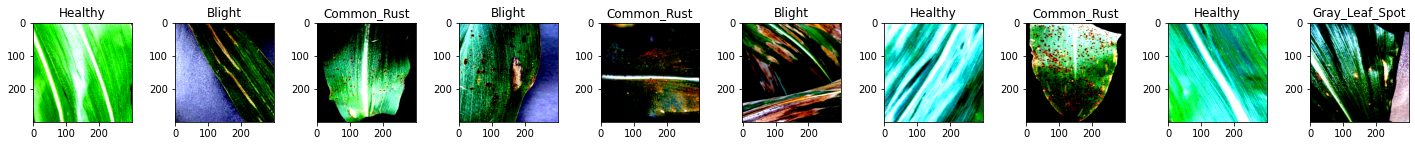

In [8]:
def im_convert(tensor):
    img = tensor.clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    # img = img*np.array(([0.485, 0.456, 0.406])/np.array(([0.229, 0.224, 0.225])))
    return img


dataiter = iter(trainloader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for i in np.arange(10):
    ax = fig.add_subplot(2, 10, i + 1)
    plt.imshow(im_convert(images[i]))
    ax.set_title(traindata.classes[labels[i].item()])


In [14]:
model = models.inception_v3();

c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [15]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(traindata.classes))
model = model.to(device)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
running_loss_history = []
val_running_loss_historu = []

running_loss_correct = []
val_running_loss_correct = []
epochs = 10


def train(model, epochs=20):
    for i in range(epochs):
        running_loss = 0.0
        val_running_loss = 0.0

        running_correct = 0.0
        val_running_correct = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            optimizer.zero_grad()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            running_correct += torch.sum(pred == labels.data)

        else:
            with torch.no_grad():
                for val_inputs, val_labels in validationloader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs, _ = model(val_inputs)
                    val_loss = loss_fn(val_outputs, val_labels)
                    _, val_pred = torch.max(val_outputs, 1)
                    val_running_correct += torch.sum(val_pred == val_labels.data)
                    val_running_loss += val_loss.item()

            val_epoch_accuracy = val_running_correct.float() / len(validationloader.dataset)
            val_epoch_loss = val_running_loss / len(validationloader.dataset)
            val_running_loss_historu.append(val_epoch_loss)
            val_running_loss_correct.append(val_epoch_accuracy)

            epoch_accuracy = running_correct.float() / len(trainloader.dataset)

            epoch_loss = running_loss / len(trainloader.dataset)
            running_loss_history.append(epoch_loss)
            running_loss_correct.append(epoch_accuracy)
            mlflow.log_metric("train_loss", f"{epoch_loss:2f}", step=i)
            mlflow.log_metric("train_accuracy", f"{epoch_accuracy.item():2f}", step=i)
            mlflow.log_metric("val_loss", f"{val_epoch_loss:2f}", step=i)
            mlflow.log_metric("val_accuracy", f"{val_epoch_accuracy.item():2f}", step=i)
            print("Epoch:{}".format(i))
            print("Training loss:{} and Accuracy:{}".format(epoch_loss, epoch_accuracy.item()))
            print("Validation loss: {} and Accuracy:{}".format(val_epoch_loss, val_epoch_accuracy.item()))

In [ ]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": 0.001,
        "batch_size": 30,
        "loss_function": loss_fn.__class__.__name__,
        "optimizer": "SGD",
    }
    mlflow.log_params(params)
    with open("model_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")
    train(model, epochs)
    mlflow.pytorch.log_model(model, "model")

Epoch:0
Training loss:0.022296287372930726 and Accuracy:0.32686567306518555
Validation loss: 0.021566841369028023 and Accuracy:0.4200477600097656
Epoch:1
Training loss:0.02043607359501853 and Accuracy:0.5107462406158447
Validation loss: 0.020628864554630543 and Accuracy:0.5131264925003052
Epoch:2
Training loss:0.01899661759832012 and Accuracy:0.5779104232788086
Validation loss: 0.018982305447070864 and Accuracy:0.6038186550140381
Epoch:3
Training loss:0.017641600939764905 and Accuracy:0.6447761058807373
Validation loss: 0.017075732243658534 and Accuracy:0.6897374987602234
Epoch:4
Training loss:0.01642723811206533 and Accuracy:0.6898507475852966
Validation loss: 0.016155173784224118 and Accuracy:0.6897374987602234
Epoch:5
Training loss:0.015419636822458524 and Accuracy:0.7167164087295532
Validation loss: 0.014922025095591398 and Accuracy:0.7374702095985413
Epoch:6
Training loss:0.01448075881644861 and Accuracy:0.7420895099639893
Validation loss: 0.014081515531835806 and Accuracy:0.76849

2024/03/22 01:16:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
c:\users\ramprakash pg\anaconda3\envs\myenv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


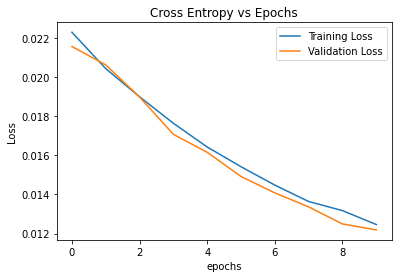

In [19]:
plt.plot(running_loss_history, label="Training Loss")
plt.plot(val_running_loss_historu, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Cross Entropy vs Epochs")
plt.legend()

In [34]:
running_loss_correct = [i.cpu() for i in running_loss_correct]
val_running_loss_correct = [i.cpu() for i in val_running_loss_correct]

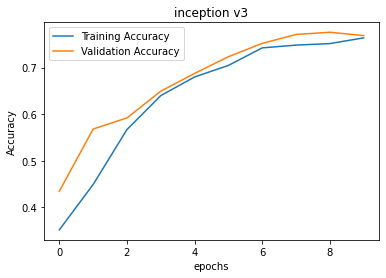

In [35]:
plt.plot(running_loss_correct, label="Training Accuracy")
plt.plot(val_running_loss_correct, label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("inception v3")
plt.legend()

In [22]:
torch.save(model, './inceptionV3_corn_maize.pth')

In [32]:
for i in range(12):
    torch.cuda.empty_cache()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


<ipython-input-5-06df581d3390>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(25, 4))


NameError: name 'im_convert' is not defined

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

<Figure size 1800x288 with 0 Axes>

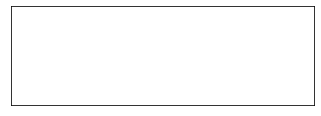

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test, y_pred = [], []
model1 = torch.load("./inceptionV3_corn_maize.pth")
for images, labels in testloader:
    y_test.extend(labels.data.cpu().numpy())
    images = images.to(device)
    labels = labels.to(device)
    output, _ = model1(images)
    _, preds = torch.max(output, 1)
    y_pred.extend(preds.data.cpu().numpy())
    fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx] == labels[idx] else "red"))

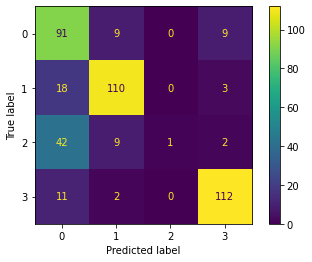

In [6]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

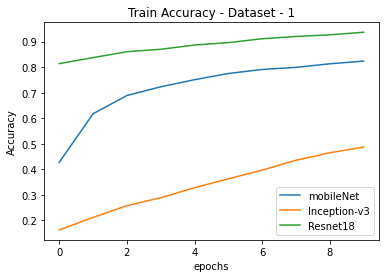

In [7]:
import matplotlib.pyplot as plt
import numpy as np

tomato={'resnet':[0.81387341, 0.83743423, 0.86056948, 0.87000929 ,0.88676106, 0.89612349, 0.91136645, 0.92018725, 0.9266481, 0.93678428],'inception':[0.16266295313835144,0.21159721910953522,0.25793972611427307,0.2886542081832886,0.32811108231544495,0.3626938760280609,0.3968124985694885,0.4355730712413788,0.4647789001464844,0.4871378242969513],'mobileNet':[0.42769266,0.61764933,0.68898948,0.72311204,0.75100588,0.77526308,0.79100898,0.79928815,0.81321572,0.82377747]}
corn={'mobileNet':[0.32544910179640716,
   0.4655688622754491,
   0.5847305389221557,
   0.6988023952095809,
   0.7646706586826348,
   0.782934131736527,
   0.7895209580838323,
   0.8077844311377245,
   0.8140718562874251,
   0.8188622754491018],'inception':[0.32686567306518555, 0.5107462406158447,0.5779104232788086,0.6447761058807373,0.6898507475852966,0.7167164087295532,0.7420895099639893,0.7582089304924011,0.7561193704605103,0.7695522308349609],'resnet':[0.6736526946107784,
   0.7844311377245509,
   0.7952095808383234,
   0.7964071856287426,
   0.8059880239520957,
   0.8119760479041916,
   0.8188622754491018,
   0.8251497005988024,
   0.8350299401197604,
   0.838622754491018]}
plant={'mobileNet':[0.6755557006234292, 0.8057903841759963, 0.878610830042106, 0.9171916310343703, 0.939093253255867, 0.9520840813395567, 0.9640957012762347, 0.9669027646310018, 0.9735940203022489, 0.9787185429382772] ,'resnet':[0.707869569474818, 0.8439468616378888, 0.898390834611744, 0.9249600156673303, 0.9407252668342201, 0.9533896922022392, 0.9608969546626628, 0.9690243822828606, 0.973659300845383, 0.9792407872833502]}
plt.plot(tomato['mobileNet'],label="mobileNet")
plt.plot(tomato['inception'],label="Inception-v3")
plt.plot(tomato['resnet'],label="Resnet18")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy - Dataset - 1")
plt.legend()

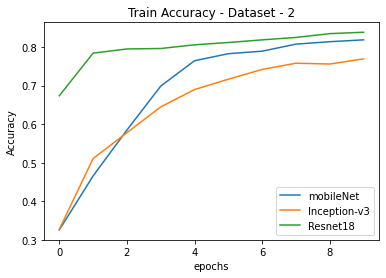

In [10]:
plt.plot(corn['mobileNet'],label="mobileNet")
plt.plot(corn['inception'],label="Inception-v3")
plt.plot(corn['resnet'],label="Resnet18")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy - Dataset - 2")
plt.legend()


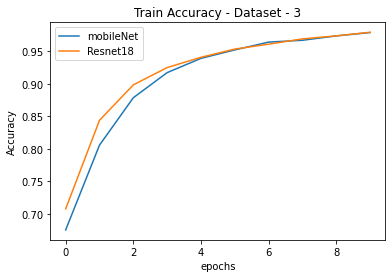

In [9]:
plt.plot(plant['mobileNet'],label="mobileNet")
plt.plot(plant['resnet'],label="Resnet18")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy - Dataset - 3")
plt.legend()
